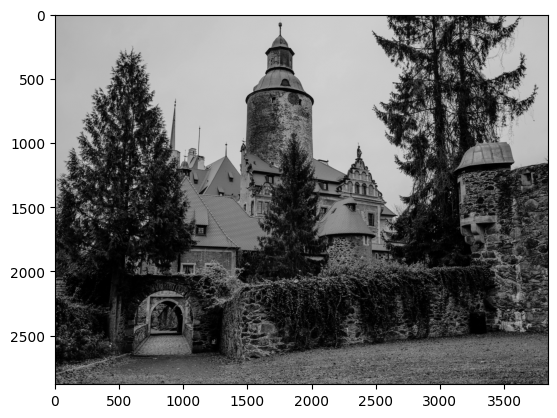

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage as ski
import time
import pycuda.driver as drv
import pycuda.autoinit
from pycuda.compiler import SourceModule

# Load an image from file
imagenEntrada = cv2.imread('pexels_borde.jpg')

# Convert the image to grayscale
imagen = cv2.cvtColor(imagenEntrada, cv2.COLOR_BGR2GRAY)

# Show the Gray Image
plt.imshow(imagen, cmap='gray')

Kernel generado con exito
Tiempo de ejecucion - Secuencial: 99.98413520000031 segundos
Procesando: 2880x3840
Padded: 2944x3904
✓ Kernel compilado exitosamente
Configuración 1D:
  Total píxeles: 11059200
  Hilos por bloque: 12
  Número de bloques: 921600
  Grid: (921600,), Block: (12,)
✓ Kernel ejecutado exitosamente
Tiempo GPU: 0.873638 s
Valores GPU - Min: -901576.00, Max: 796517.00


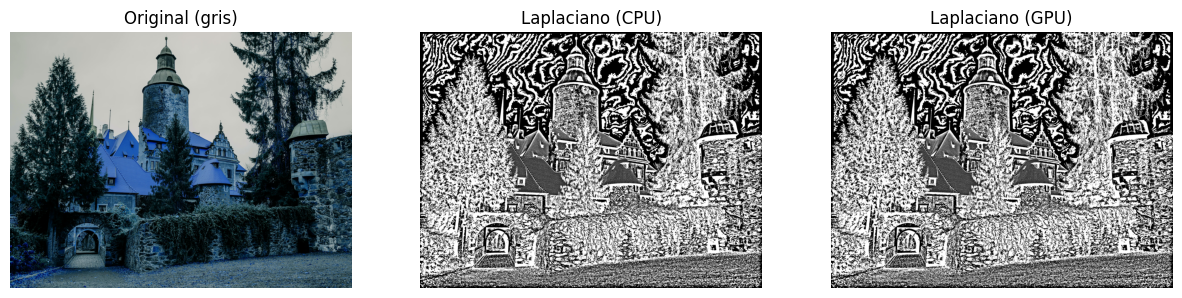

In [23]:
# Generacion del Kernel
def generar_Kernel(numero: int):
    if numero % 2 == 0:
        raise ValueError("El numero debe ser impar")
    else:
        kernel = np.ones((numero, numero), np.float32)
        kernel[numero //2, numero //2] = -1 * (numero * numero - 1)
        return kernel


# Funcion para el filtro secuencial
def filtro_laplace_secuencial(imagen: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    matrizImagen = imagen.astype(np.float32)

    k = kernel.shape[0]
    pad = k // 2
    h, w = matrizImagen.shape

    imagenPadded = np.pad(matrizImagen, pad, mode='constant', constant_values=0)

    salida = np.zeros_like(matrizImagen, dtype=np.float32)

    for i in range(h):
        for j in range(w):
            region = imagenPadded[i:i + k, j:j + k]
            salida[i, j] = np.sum(region * kernel)
            
    salida = np.clip(salida, 0, 255).astype(np.uint8)
    return salida


# Funcion paralela usando PyCUDA
def filtro_laplace_paralelo(imagen: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    matrizImagen = imagen.astype(np.float32)
    k = kernel.shape[0]
    pad = k // 2
    alto, ancho = matrizImagen.shape
    
    print(f"Procesando: {alto}x{ancho}")

    # Padding con zeros
    imagenPadded = np.pad(matrizImagen, ((pad, pad), (pad, pad)), 
                          mode='constant', constant_values=0.0)
    
    # Asegurar que todo esté contiguo y en float32
    imagenPadded = np.ascontiguousarray(imagenPadded, dtype=np.float32)
    salida = np.zeros((alto, ancho), dtype=np.float32, order='C')
    kernel_flat = np.ascontiguousarray(kernel.flatten(), dtype=np.float32)
    
    altoPadded, anchoPadded = imagenPadded.shape
    print(f"Padded: {altoPadded}x{anchoPadded}")

    # Kernel CUDA con indexación 1D y tamaño dinámico
    kernel_code = """
    __global__ void filtro_laplace(float *imagen, float *kernel, float *salida,
                                int ancho, int alto, int k, int anchoPadded) {
        int idx = blockIdx.x * blockDim.x + threadIdx.x;
        int totalPixels = ancho * alto;
        
        if (idx >= totalPixels) return;
        
        int y = idx / ancho;
        int x = idx % ancho;

        float suma = 0.0f;
        
        // Usar k dinámicamente (no hardcoded a 3)
        for (int ky = 0; ky < k; ky++) {
            for (int kx = 0; kx < k; kx++) {
                int posY = y + ky;
                int posX = x + kx;
                int idxImg = posY * anchoPadded + posX;
                int idxKer = ky * k + kx;  // Usar k, no 3
                suma += imagen[idxImg] * kernel[idxKer];
            }
        }
        
        salida[idx] = suma;
    }
    """

    # Compilar
    try:
        mod = SourceModule(kernel_code, 
                          options=['--use_fast_math'],
                          no_extern_c=False)
        print("✓ Kernel compilado exitosamente")
    except Exception as e:
        print(f"✗ Error de compilación: {e}")
        try:
            mod = SourceModule(kernel_code, no_extern_c=True)
            print("✓ Kernel compilado (sin optimizaciones)")
        except Exception as e2:
            print(f"✗ Error crítico: {e2}")
            raise

    laplace_kernel = mod.get_function("filtro_laplace")
    
    # Configuración 1D con 12 hilos por bloque
    THREADS_PER_BLOCK = 12
    totalPixels = alto * ancho
    numBlocks = (totalPixels + THREADS_PER_BLOCK - 1) // THREADS_PER_BLOCK
    
    print(f"Configuración 1D:")
    print(f"  Total píxeles: {totalPixels}")
    print(f"  Hilos por bloque: {THREADS_PER_BLOCK}")
    print(f"  Número de bloques: {numBlocks}")
    print(f"  Grid: ({numBlocks},), Block: ({THREADS_PER_BLOCK},)")

    tiempoInicial = time.perf_counter()

    try:
        # Asignar memoria GPU
        imagen_gpu = drv.mem_alloc(imagenPadded.nbytes)
        kernel_gpu = drv.mem_alloc(kernel_flat.nbytes)
        salida_gpu = drv.mem_alloc(salida.nbytes)
        
        # Copiar a GPU
        drv.memcpy_htod(imagen_gpu, imagenPadded)
        drv.memcpy_htod(kernel_gpu, kernel_flat)
        
        # Ejecutar kernel con configuración 1D
        laplace_kernel(
            imagen_gpu,
            kernel_gpu,
            salida_gpu,
            np.int32(ancho),
            np.int32(alto),
            np.int32(k),
            np.int32(anchoPadded),
            block=(THREADS_PER_BLOCK, 1, 1),  # 12 hilos en X, 1 en Y, 1 en Z
            grid=(numBlocks, 1)                 # numBlocks en X, 1 en Y
        )
        
        # Copiar resultado
        drv.memcpy_dtoh(salida, salida_gpu)
        
        # Liberar memoria
        imagen_gpu.free()
        kernel_gpu.free()
        salida_gpu.free()
        
        print("✓ Kernel ejecutado exitosamente")
        
    except Exception as e:
        print(f"✗ Error de ejecución: {e}")
        raise

    tiempoFinal = time.perf_counter()
    print(f"Tiempo GPU: {tiempoFinal - tiempoInicial:.6f} s")

    # Diagnóstico de valores antes del clip
    print(f"Valores GPU - Min: {salida.min():.2f}, Max: {salida.max():.2f}")
    
    # Clip y conversión
    salida = np.clip(salida, 0, 255).astype(np.uint8)
    return salida


# Ejecución
kernel = generar_Kernel(65)
print("Kernel generado con exito")

# Filtro Secuencial
tiempoInicial = time.perf_counter()
resultado = filtro_laplace_secuencial(imagen, kernel)
tiempoFinal = time.perf_counter()
print(f"Tiempo de ejecucion - Secuencial: {tiempoFinal - tiempoInicial} segundos")

# Filtro Paralelo
resultadoParalelo = filtro_laplace_paralelo(imagen, kernel)


# Mostrar resultados
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title("Original (gris)")
plt.imshow(imagenEntrada, cmap='gray')
plt.axis('off')

plt.subplot(1,3,2)
plt.title("Laplaciano (CPU)")
plt.imshow(resultado, cmap='gray')
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Laplaciano (GPU)")
plt.imshow(resultadoParalelo, cmap='gray')
plt.axis('off')

plt.show()

In [19]:
kernel = generar_Kernel(3)
kernelOriginal = kernel
kernelFlt = kernel.flatten()

print(f"Kernel Original:\n{kernelOriginal}")
print(f"Kernel Flattened:\n{kernelFlt}")

Kernel Original:
[[ 1.  1.  1.]
 [ 1. -8.  1.]
 [ 1.  1.  1.]]
Kernel Flattened:
[ 1.  1.  1.  1. -8.  1.  1.  1.  1.]
